# Notebook Overview
This notebook is the source for `glm_gridder.py` and is maintained for the purpose of breaking down glm_gridder.py into understandable chunks. <br/>

The data pipeline in this notebook is set up to take input GLM data files from the input directory `raw_dir`, input it into the gridder to layer and reformat the flash information, and output the processed data to the file stored as the `out_dir` variable. Once the data has been sent to the output file, the data in the output file can be plotted to show the accumulation of the lightning flashes over time. <br/>

The general overview of the data pipeline is as follows: <br/>
GLM data files → input directory  (`raw_dir`)→ gridder → out file (`out_dir`)  → plotting

In [1]:
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
from examples.grid.make_GLM_grids import create_parser as create_grid_parser
from examples.grid.make_GLM_grids import grid_setup
from multiprocessing import freeze_support
import netCDF4

plt.rcParams["figure.figsize"] = (25,12)

# Pipeline Configuration
The following cell defines the variables which dictate where the GLM files are stored (`raw_dir`), the characteristics of the gridder that will be used to layer and process the data, and the location of the output file (`out_dir`). The name `out_dir` is misleading as `out_dir` needs to be the location of a specific netCDF file.

Something that might be worth working on in the future is passing arugments to the gridder in a way that doesn't require a seperate parser. 

In [2]:
# Define output directory and file.
out_dir = '../../../data/out_dir/gridded_data.nc'
open(out_dir, 'w').close() # empty output file

# Define input file directory and generate list of filenames and paths.
raw_dir = '../../../data/raw_dir/'
files = [raw_dir + f for f in listdir(raw_dir)][:]
print('using ' + str(len(files)) + ' files')

# Define grid characteristics.
grid_spec = ["--fixed_grid", "--split_events",
                "--goes_position", "east", "--goes_sector", "conus",
                "--dx=2.0", "--dy=2.0",
                # "--ctr_lat=33.5", "--ctr_lon=-101.5",
                ]
# Set up arguments for gridder creation.
cmd_args = ["-o", out_dir] + grid_spec + files
grid_parser = create_grid_parser()
grid_args = grid_parser.parse_args(cmd_args)    

# Create gridder for data processing.
freeze_support()
gridder, glm_filenames, start_time, end_time, grid_kwargs = grid_setup(grid_args)

# print('start time ' + str(start_time))
# print('end time ' + str(end_time))
# print(glm_filenames)
# for f in glm_filenames:
#   print(f)

using 18 files


# Gridding and Plotting
This section of the notebook is for calling the gridder to generate the layered data and then displaying it as an image. 

The gridder is a function from glm tools that takes the data from each file and re-shapes it into different variables in a netCDF file. The gridder is pretty RAM-intensive to run so at some point it may be worth going into the package code and making sure it's written as well as it can be. 

Once the grid has been made, we select the `flash_extent densidty` variable from the output netCDF file. This variable is not part of the original netCDF files and is calculated during gridding. This is the variable that will be used as an input into the AACP-identifying U-net. 

In [3]:
# Create grid and define output data.
the_grid = gridder(glm_filenames, start_time, end_time, **grid_kwargs)
glm_data = netCDF4.Dataset(out_dir, "r", "NETCDF4")

In [4]:
# print(glm_data.variables)

In [5]:
goes_image_proj = np.copy(np.asarray(glm_data.variables['flash_extent_density'][:])) # select specific variable to plot

In [6]:
print(goes_image_proj.shape) # verfiy that the variable is shaped like an image

(1500, 2500)


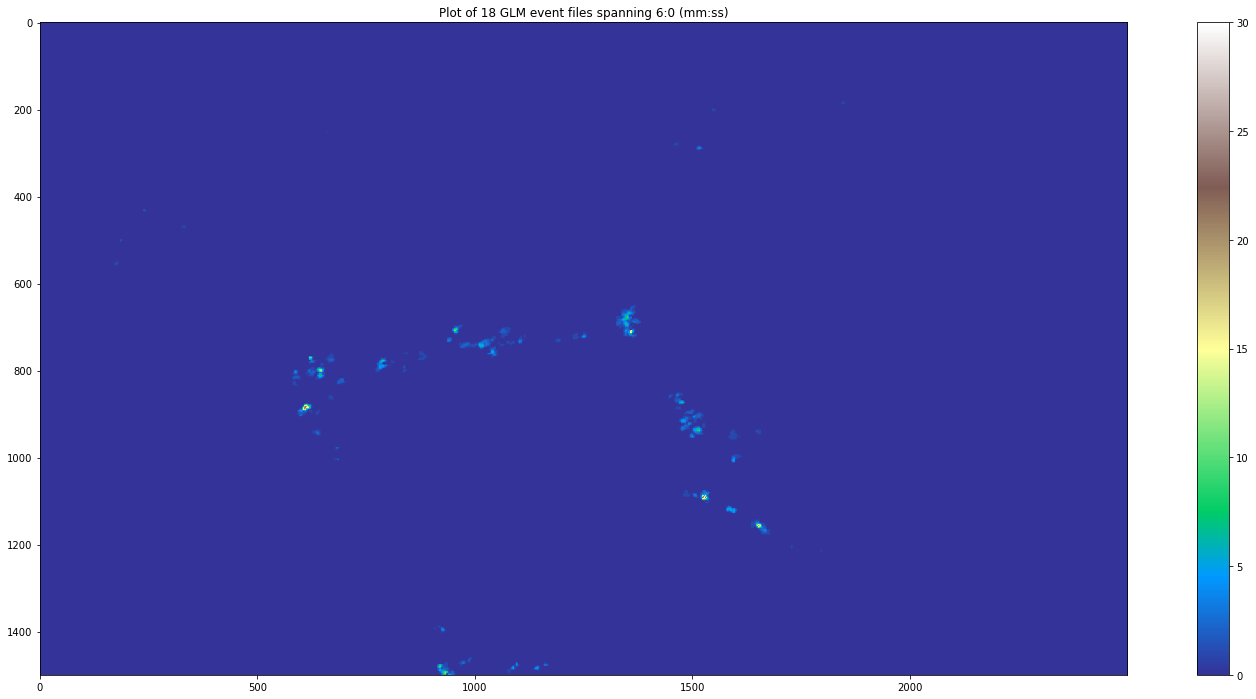

In [7]:
# Plot creation styling.

the_time_change = (end_time - start_time)
time_seconds = the_time_change.seconds % 60
time_minutes = int((the_time_change.seconds - time_seconds)/60)
plt.title('Plot of ' + str(len(files)) + ' GLM event files spanning ' + str(time_minutes) +':' + str(time_seconds) + ' (mm:ss)')
plt.imshow(goes_image_proj, cmap="terrain")
plt.colorbar()
plt.show()